In [64]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from string import punctuation
import datetime
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda
from keras.models import Model
import keras.backend as K
import re
from keras.losses import binary_crossentropy
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import codecs

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import datetime
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import time

warnings.filterwarnings("ignore")
pd.set_option('max_columns', None)

In [65]:
path1 = '/kaggle/input/nfl-big-data-bowl-2020/train.csv'
path2 = '../input/nfl-big-data-bowl-2020/train.csv'
if os.path.exists(path1):
    df = pd.read_csv(path1)
    TRAIN_OFFLINE = False

else:
    df = pd.read_csv(path2)
    TRAIN_OFFLINE = True
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

In [32]:
df.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,diffScoreBeforePlay,num_WR,DL_LB,SUB_DL_BL,num_DL,num_BL,PlayerHeight_dense,PlayerBMI,kg,True_Momentum,Force_Newtons,JerseyNumber_fix,back_scrim_away,back_scrim_home
0,2017090700,20170907000118,away,46.09,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,72,28.749228,9.812406,15.163465,10.138885,29,-13.179091,-9.057273
1,2017090700,20170907000118,away,45.33,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,75,35.993600,13.330061,5.119383,16.455161,97,-13.179091,-9.057273
2,2017090700,20170907000118,away,46.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,75,33.744000,12.496933,13.941178,6.742045,50,-13.179091,-9.057273


In [7]:
df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
df[df['NflId']==df['NflIdRusher']][['diffScoreBeforePlay', 'Yards']].corr()

,diffScoreBeforePlay,Yards
diffScoreBeforePlay,1.000000,-0.012502
Yards,-0.012502,1.000000


# OffenseFormation

In [36]:
df[df['NflId']==df['NflIdRusher']]['Position'].value_counts()

RB    21628
WR      638
HB      616
FB      169
QB       77
TE       31
CB        9
DT        2
DE        1
Name: Position, dtype: int64

In [8]:
tmp = df[df['NflId'] == df['NflIdRusher']][['OffenseFormation', 'Yards']]
tmp['OffenseFormation'] = tmp['OffenseFormation'].fillna('unknown')
tmp.groupby(['OffenseFormation']).Yards.std().sort_values()

OffenseFormation
unknown       0.836660
WILDCAT       4.034229
JUMBO         5.526517
PISTOL        5.545409
EMPTY         5.803434
SHOTGUN       6.085829
I_FORM        6.551639
SINGLEBACK    6.687501
ACE                NaN
Name: Yards, dtype: float64

In [9]:
key = ['JUMBO', 'unknown', 'ACE', 'I_FORM', 'SINGLEBACK', 'WILDCAT', 'PISTOL',
       'SHOTGUN', 'EMPTY']
val = [1.756238  , 2.8       , 4.        , 4.02240199, 4.22211379,
       4.22222222, 4.29836066, 4.50816089, 5.04347826]
dict(zip(key, val))

{'ACE': 4.0,
 'EMPTY': 5.04347826,
 'I_FORM': 4.02240199,
 'JUMBO': 1.756238,
 'PISTOL': 4.29836066,
 'SHOTGUN': 4.50816089,
 'SINGLEBACK': 4.22211379,
 'WILDCAT': 4.22222222,
 'unknown': 2.8}

# Offense/Defense Personnel

In [10]:
def get_num_offense(row):
    splits = row.split(', ')
    cnt = 0
    for s in splits:
        if 'WR' in s:
            return int(s[0])
    return 0
df['num_WR'] = df['OffensePersonnel'].apply(get_num_offense)
df[df['NflId']==df['NflIdRusher']][['num_WR', 'Yards']].corr()

,num_WR,Yards
num_WR,1.000000,0.064406
Yards,0.064406,1.000000


In [37]:
# Create the DL-LB combos
df['DL_LB'] = df['DefensePersonnel'] \
    .str[:10] \
    .str.replace(' DL, ','-') \
    .str.replace(' LB','') # Clean up and convert to DL-LB combo
df['SUB_DL_BL'] = df['DL_LB'].apply(lambda x: int(x.split('-')[0]) - int(x.split('-')[1]))
df.groupby(['SUB_DL_BL']).Yards.mean().sort_values

<bound method Series.sort_values of SUB_DL_BL
-6    4.000000
-5    4.166667
-4    4.857143
-3    4.643678
-2    4.405618
-1    4.033866
 0    4.280355
 1    3.953052
 2    4.455588
 3    4.694888
 4    1.473684
 5    0.500000
Name: Yards, dtype: float64>

In [47]:
df['num_DL'] = df['DL_LB'].apply(lambda x: x.split('-')[0]).astype(int)
df[df['NflId']==df['NflIdRusher']].groupby(['num_DL']).Yards.mean().sort_values()

num_DL
6    0.323529
7    1.000000
5    2.776316
3    4.163305
4    4.233653
2    4.522345
1    5.163636
0    5.416667
Name: Yards, dtype: float64

In [48]:
df['num_BL'] = df['DL_LB'].apply(lambda x: x.split('-')[0]).astype(int)
df[df['NflId']==df['NflIdRusher']].groupby(['num_BL']).Yards.mean().sort_values()

num_BL
6    0.323529
7    1.000000
5    2.776316
3    4.163305
4    4.233653
2    4.522345
1    5.163636
0    5.416667
Name: Yards, dtype: float64

# DefendersInTheBox

In [18]:
df['DefendersInTheBox'] = df['DefendersInTheBox'].apply(lambda x: 2.0 if x == 1.0 else x)
defense_df = df.groupby(['DefendersInTheBox']).aggregate({'Yards': 'mean'})
defense_df

,Yards
DefendersInTheBox,
2.0,15.500000
3.0,10.611111
4.0,7.347458
5.0,5.826023
6.0,4.694505
7.0,4.212492
8.0,3.638302
9.0,2.821604
10.0,0.796791


# Height/Weight

In [43]:
df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight_dense'])**2)

In [44]:
df['kg']=df["PlayerWeight"] * 0.45359237 / 9.8
# the momentum is just mass (in kg) X speed in m/s (so convert from yards/sec to mps)
df['True_Momentum']=df['kg'] * df['S'] * 0.9144 
df['Force_Newtons']=df['kg'] * df['A'] * 0.9144

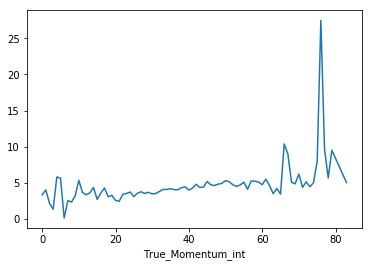

In [55]:
df['True_Momentum_int'] = df['True_Momentum'].astype(int)
df[df['NflId']==df['NflIdRusher']].groupby(['True_Momentum_int']).Yards.mean().plot()

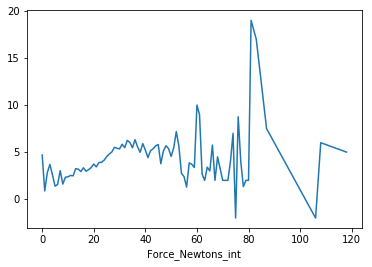

In [54]:
df['Force_Newtons_int'] = df['Force_Newtons'].astype(int)
df[df['NflId']==df['NflIdRusher']].groupby(['Force_Newtons_int']).Yards.mean().plot()
#maybe don't useful

# JerseyNumber

In [22]:
df['JerseyNumber'].value_counts()

21    11158
23    10072
90     9164
26     9115
24     8899
77     8630
98     8613
94     8375
71     8205
93     8023
22     8010
20     7944
97     7819
99     7755
25     7626
54     7589
73     7481
11     7442
75     7358
10     7303
76     7237
55     7218
72     7199
29     7064
27     7057
65     7038
70     6828
74     6805
95     6717
91     6685
      ...  
38     3926
42     3903
83     3566
19     3560
36     3447
15     3396
34     3263
44     3172
86     3121
16     3105
37     2961
43     2930
48     2731
47     2596
4      2546
35     2392
39     2277
7      2252
3      2147
63     2117
8      1949
5      1881
9      1820
40     1612
45     1608
46     1156
49     1112
2       997
6       810
1       592
Name: JerseyNumber, Length: 99, dtype: int64

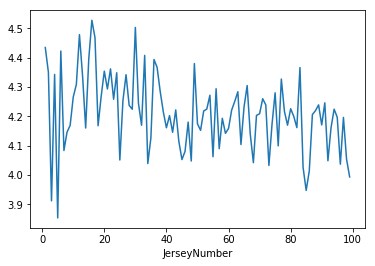

In [23]:
df.groupby(['JerseyNumber']).Yards.mean().plot()

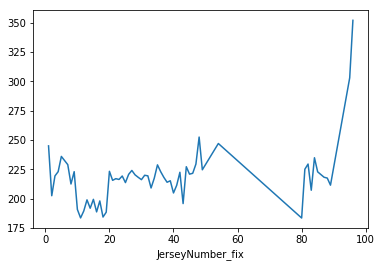

In [24]:
df['JerseyNumber'] = df['JerseyNumber'].fillna(-999)
df['JerseyNumber_fix'] = df['JerseyNumber']
data = df[df['NflId']==df['NflIdRusher']].groupby(['JerseyNumber_fix']).PlayerWeight.mean().plot()

In [25]:
df[['Yards', 'PlayerBMI', 'PlayerHeight_dense', 'PlayerWeight', 'JerseyNumber']].corr()

,Yards,PlayerBMI,PlayerHeight_dense,PlayerWeight,JerseyNumber
Yards,1.000000,-0.008167,-0.007857,-0.008862,-0.008038
PlayerBMI,-0.008167,1.000000,0.473257,0.949165,0.694086
PlayerHeight_dense,-0.007857,0.473257,1.000000,0.723726,0.567839
PlayerWeight,-0.008862,0.949165,0.723726,1.000000,0.739988
JerseyNumber,-0.008038,0.694086,0.567839,0.739988,1.000000


In [26]:
df[df['NflId']==df['NflIdRusher']].groupby(['Position']).Yards.mean().sort_values()

Position
DE    0.000000
DT    1.000000
QB    2.363636
FB    3.041420
RB    4.172739
TE    4.258065
HB    4.318182
WR    5.921630
CB    9.777778
Name: Yards, dtype: float64

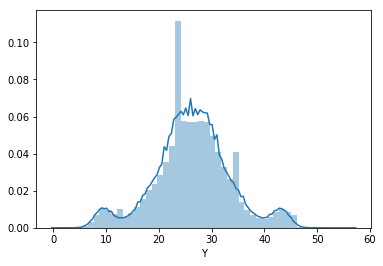

In [27]:
sns.distplot(df['Y'].astype(int))

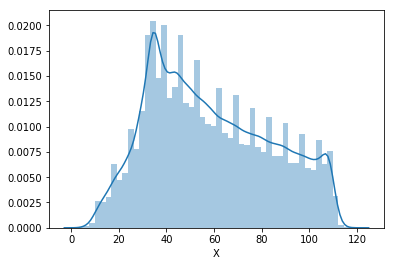

In [28]:
sns.distplot(df['X'].astype(int))

In [29]:
rusher = df[df['NflId'] == df['NflIdRusher']][['GameId', 'PlayId', 'Team']]
rusher.columns = ['GameId', 'PlayId', 'RusherTeam']
tmp = pd.merge(df[['GameId', 'PlayId', 'Team', 'X', 'YardLine']], rusher, on=['GameId', 'PlayId'], how='left')
tmp['back_scrim'] = tmp['YardLine'] - tmp['X']
tmp_away = tmp[tmp['Team'] != tmp['RusherTeam']].groupby(['GameId', 'PlayId'])['back_scrim'].mean().reset_index()
tmp_away.columns = ['GameId', 'PlayId', 'back_scrim_away']
df = pd.merge(df, tmp_away, on=['GameId', 'PlayId'], how='left')
tmp_home = tmp[tmp['Team'] == tmp['RusherTeam']].groupby(['GameId', 'PlayId'])['back_scrim'].mean().reset_index()
tmp_home.columns = ['GameId', 'PlayId', 'back_scrim_home']
df = pd.merge(df, tmp_home, on=['GameId', 'PlayId'], how='left')
    

In [30]:
df[df['NflId']==df['NflIdRusher']][['back_scrim_away', 'back_scrim_home', 'A', 'Yards', 'S']].corr()['Yards']

back_scrim_away    0.103173
back_scrim_home    0.106263
A                  0.158868
Yards              1.000000
S                  0.084061
Name: Yards, dtype: float64

In [31]:
df.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,diffScoreBeforePlay,num_WR,DL_LB,SUB_DL_BL,num_DL,num_BL,PlayerHeight_dense,PlayerBMI,kg,True_Momentum,Force_Newtons,JerseyNumber_fix,back_scrim_away,back_scrim_home
0,2017090700,20170907000118,away,46.09,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,72,28.749228,9.812406,15.163465,10.138885,29,-13.179091,-9.057273
1,2017090700,20170907000118,away,45.33,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,75,35.993600,13.330061,5.119383,16.455161,97,-13.179091,-9.057273
2,2017090700,20170907000118,away,46.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0,3,2-3,-1,2,2,75,33.744000,12.496933,13.941178,6.742045,50,-13.179091,-9.057273


In [56]:
df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
seconds_in_year = 60*60*24*365
df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
   

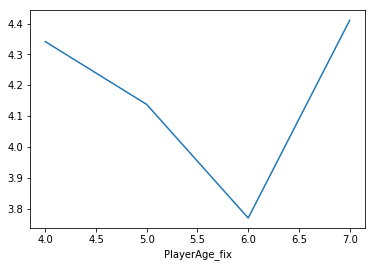

In [61]:
df['PlayerAge_fix'] = df['PlayerAge']//5
df[df['NflId']==df['NflIdRusher']].groupby(['PlayerAge_fix']).Yards.mean().plot()

In [66]:
df['Position_int'] = df['Position'].apply(lambda x: 1 if x=='RB' else 0)
df[df['NflId']==df['NflIdRusher']].groupby(['Position_int']).Yards.mean()

Position_int
0    4.767336
1    4.172739
Name: Yards, dtype: float64